# RFM-анализ

1. По данным покупок проведем анализ пользователей в плоскости Recency-Frequency-Monetary.

2. Попробуем предсказать расход пользователей, используя данные из перового этапа как параметры предиктивной модели.

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "drive/MyDrive/"
file_path = os.path.join(drive_path, 'scanner_data.csv')

Используем датасет из открытых источников.

https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions


In [ ]:
df = pd.read_csv(file_path, parse_dates=['Date'], index_col=0)
df.head(10)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
4,2016-02-01,3719,4,0H2,549KK,1.0,5.59
5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88
6,2016-02-01,5010,6,JPI,GVBRC,1.0,10.77
7,2016-02-01,1666,7,XG4,AHAE7,1.0,3.65
8,2016-02-01,1666,7,FEW,AHZNS,1.0,8.21
9,2016-02-01,1253,8,0H2,9STQJ,1.0,8.25
10,2016-02-01,5541,9,N5F,7IE9S,1.0,8.18


In [ ]:
df.describe(datetime_is_numeric=True)

,Date,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706,131706.000000,131706.000000,131706.000000,131706.000000
mean,2016-07-05 15:47:54.456744704,12386.450367,32389.604187,1.485311,11.981524
min,2016-01-02 00:00:00,1.000000,1.000000,0.010000,0.020000
25%,2016-04-06 00:00:00,7349.000000,16134.000000,1.000000,4.230000
50%,2016-07-06 00:00:00,13496.000000,32620.000000,1.000000,6.920000
75%,2016-10-06 00:00:00,17306.000000,48548.000000,1.000000,12.330000
max,2016-12-31 00:00:00,22625.000000,64682.000000,400.000000,707.730000
std,NaN,6086.447552,18709.901238,3.872667,19.359699


In [ ]:
print(f"Number of customers in dataset: {df.Customer_ID.nunique()}")
print(f"Number of SKU Groups in dataset: {df.SKU_Category.nunique()}")
print(f"Date range: {df.Date.min()} - {df.Date.max()}")

Number of customers in dataset: 22625
Number of SKU Groups in dataset: 187
Date range: 2016-01-02 00:00:00 - 2016-12-31 00:00:00


## Очистка данных

Нам понадобятся только следующие колонки:
- `Date`
- `Customer ID`
- `Tranasction ID`
- `Quantity`
- `Sales Amount`

In [ ]:
df_cleaned = df[['Date', 'Customer_ID', 'Transaction_ID', 'Quantity', 'Sales_Amount']]
df_cleaned.head()

,Date,Customer_ID,Transaction_ID,Quantity,Sales_Amount
1,2016-02-01,2547,1,1.0,3.13
2,2016-02-01,822,2,1.0,5.46
3,2016-02-01,3686,3,1.0,6.35
4,2016-02-01,3719,4,1.0,5.59
5,2016-02-01,9200,5,1.0,6.88


## Создание признаков

Мы проводим RFM-анализ, поэтому нам нужно рассчитать Recency, Frequency и Monetary для каждого клиента.

- Recency (давность) — давность последней покупки. Чем меньше времени прошло с момента последней покупки, тем выше вероятность, что покупатель повторит действие;
- Frequency (частота) — количество покупок. Чем больше покупок совершил клиент, тем выше вероятность, что он совершит покупку снова;
- Monetary (деньги) — сумма покупок в денежном эквиваленте. Чем больше денег было потрачено клиентом, тем выше вероятность, что он снова совершит заказ.

In [ ]:
class RFM:
    def __init__(
        self,
        data,
        cut_off,
        date_column,
        customer_id_column,
        value_column,
        freq='M'
    ):
        self.data = data
        self.cut_off = cut_off
        self.date_column = date_column
        self.customer_id_column = customer_id_column
        self.value_column = value_column
        self.freq = freq


    def frequency(self):
        frequency = self.data[self.data[self.date_column] < self.cut_off].copy()
        frequency.set_index(self.date_column, inplace=True)
        frequency.index = pd.DatetimeIndex(frequency.index)

        frequency = frequency.groupby([
            self.customer_id_column,
            pd.Grouper(freq=self.freq, level=self.date_column)
        ]).count()
        frequency[self.value_column] = 1
        return (frequency.groupby(self.customer_id_column).sum().reset_index()
                .rename(columns={self.value_column : 'frequency'}))


    def recency(self):
        recency = self.data[self.data[self.date_column] < self.cut_off].copy()
        recency = recency.groupby(self.customer_id_column)[self.date_column].max()
        return ((pd.to_datetime(self.cut_off) - recency).dt.days) \
            .reset_index().rename(columns={self.date_column: 'recency'})


    def age(self):
        age = self.data[self.data[self.date_column] < self.cut_off].copy()
        first_purchase = age.groupby(self.customer_id_column)[self.date_column] \
            .min().reset_index()
        first_purchase['age'] = (
            pd.to_datetime(self.cut_off) - first_purchase[self.date_column]
        ).dt.days
        return first_purchase[[self.customer_id_column, 'age']]


    def value(self):
        value = self.data[self.data[self.date_column] < self.cut_off].copy()
        value.set_index(self.date_column, inplace=True)
        value.index = pd.DatetimeIndex(value.index)
        return value.groupby(self.customer_id_column)[self.value_column] \
            .mean().reset_index().rename(columns={self.value_column : 'value'})


    def calculate(self):
        return (self.frequency()
                .merge(self.recency(), on=self.customer_id_column)
                .merge(self.value(), on=self.customer_id_column)
                .merge(self.age(), on=self.customer_id_column))

## Моделирование

Мы разделим данные на наблюдаемый период и будущий период. Если мы хотим предсказать, сколько покупатель потратит через год, мы установим продолжительность будущего периода равным одному году, а остальную часть времени будем рассматривать как данные для обучения модели.


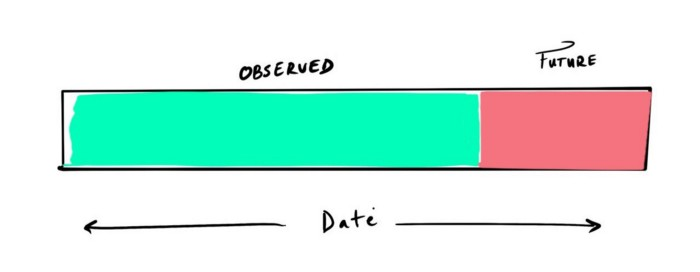


### Cut-Off
Здесь мы вводим понятие отсечки. Это просто то место, где заканчивается наблюдаемый период, то есть до какой даты мы должны вычислить наши признаки.

Продолжительность будущего периода определяет время, в течение которого мы хотим прогнозировать расходы клиентов.

In [ ]:
data_for_rfm = df_cleaned[['Date', 'Customer_ID', 'Sales_Amount']]
rfm = RFM(data_for_rfm, '2016-06-01', 'Date', 'Customer_ID', 'Sales_Amount', 'W')

In [ ]:
rfm_df = rfm.calculate()
rfm_df.head()

,Customer_ID,frequency,recency,value,age
0,1,1,131,8.145000,131
1,2,1,69,7.770000,69
2,3,1,121,3.640000,121
3,5,4,4,14.672500,100
4,6,1,62,8.516667,62


In [ ]:
start_date, end_date = df_cleaned.Date.min(), df_cleaned.Date.max()
print(start_date, end_date)

2016-01-02 00:00:00 2016-12-31 00:00:00


### Рекурсивный RFM
Мы выберем частоту (например, один месяц) и пройдемся по набору данных, вычислив наши параметры RFM на основе наблюдаемых батчей и сгенерировав метки из будущего. Идея состоит в том, чтобы рекурсивно вычислить параметры, чтобы модель могла узнать, как поведение клиентов меняется с течением времени.

In [12]:
def recursive_rfm(data,
                  date_col,
                  id_col,
                  value_col,
                  freq='M',
                  start_length=30,
                  label_period_days=30):
  df_list = []
  rfm_columns = [date_col, id_col, value_col]
  start_date = data[date_col].min() + pd.Timedelta(start_length, unit='D')
  end_date = data[date_col].max() - pd.Timedelta(label_period_days, unit='D')
  dates = pd.date_range(start=start_date, end=end_date, freq=freq)

  for cut_off in dates:
      observed = data[data[date_col] < cut_off]
      future = data[
          (data[date_col] > cut_off) &
          (data[date_col] < cut_off + pd.Timedelta(label_period_days, unit='D'))
      ]
      
      print(f"computing rfm features for {cut_off.date()} "
            f"to {future[date_col].max().date()}: {len(observed)}")
      _observed = observed[rfm_columns]
      rfm_features = RFM(_observed,
                         cut_off,
                         date_col,
                         id_col,
                         value_col).calculate()
      labels = future.groupby(id_col)[value_col].sum()
      df = rfm_features.merge(labels, on=id_col, how='outer').fillna(0) 
      df_list.append(df)
  full_df = pd.concat(df_list, axis=0)
  res = full_df[full_df.recency != 0].dropna(axis=1, how='any')
  return res

In [13]:
rec_df = recursive_rfm(data_for_rfm, 'Date', 'Customer_ID', 'Sales_Amount')

computing rfm features for 2016-02-29 to 2016-03-29: 19712
computing rfm features for 2016-03-31 to 2016-04-29: 30153
computing rfm features for 2016-04-30 to 2016-05-29: 41415
computing rfm features for 2016-05-31 to 2016-06-29: 53324
computing rfm features for 2016-06-30 to 2016-07-29: 63562
computing rfm features for 2016-07-31 to 2016-08-29: 73986
computing rfm features for 2016-08-31 to 2016-09-29: 84499
computing rfm features for 2016-09-30 to 2016-10-29: 96606
computing rfm features for 2016-10-31 to 2016-11-29: 107994
computing rfm features for 2016-11-30 to 2016-12-29: 119086


## Предиктивная модель

В качестве модели попробуем `Random Forest Regressor`.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [20]:
X = rec_df[['recency', 'frequency', 'value', 'age']]
y = rec_df[['Sales_Amount']].values.reshape(-1)

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=42,
    shuffle=True
)

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=6, random_state=42).fit(X_train, y_train)

## Результат

Сохраним прогнозы в датафрейме и посмотрим, как они соотносятся с истинными значениями.

In [22]:
predictions = pd.DataFrame({'true': y_train, 'preds': rf.predict(X_train)})
predictions_test = pd.DataFrame({'true': y_test, 'preds': rf.predict(X_test)})

In [23]:
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(predictions.true,
                                        predictions.preds))
test_rmse = np.sqrt(mean_squared_error(predictions_test.true,
                                       predictions_test.preds))

print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 25.088217617376042, Test RMSE: 25.922808821101686


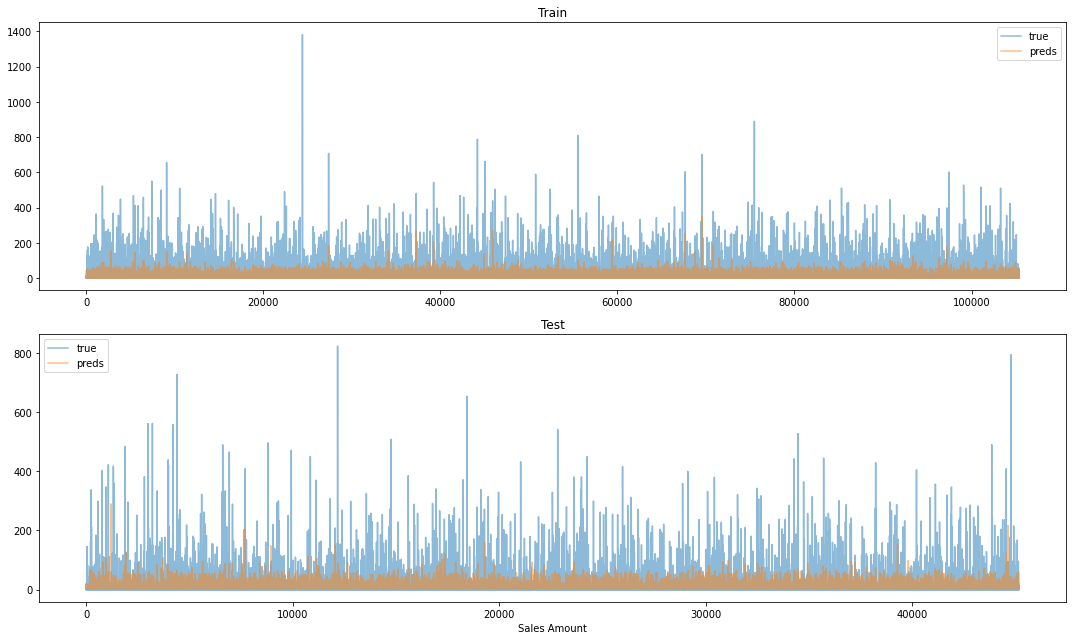

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(15, 9))
predictions.plot(ax=ax[0], title='Train', alpha=0.5)
predictions_test.plot(ax=ax[1], title='Test', alpha=0.5)
plt.xlabel('CustomerID')
plt.xlabel('Sales Amount')
plt.tight_layout()
plt.show()